In [2]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# import zipfile
# with zipfile.ZipFile("/kaggle/input/cat-dog/cat_dog_data.zip", 'r') as zip:
#     zip.extractall() 
#     print('Done!')

In [4]:
my_data_dir = '/kaggle/input/cat-dog/data'
val_path = my_data_dir+'/validation/'
train_path = my_data_dir+'/train/'
test_path = my_data_dir+'/test/'

In [5]:
for dirpath, dirnames, filenames in os.walk(my_data_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/kaggle/input/cat-dog/data'.
There are 2 directories and 0 images in '/kaggle/input/cat-dog/data/validation'.
There are 0 directories and 1071 images in '/kaggle/input/cat-dog/data/validation/dog'.
There are 0 directories and 1219 images in '/kaggle/input/cat-dog/data/validation/cat'.
There are 0 directories and 6897 images in '/kaggle/input/cat-dog/data/test'.
There are 2 directories and 0 images in '/kaggle/input/cat-dog/data/train'.
There are 0 directories and 5026 images in '/kaggle/input/cat-dog/data/train/dog'.
There are 0 directories and 12500 images in '/kaggle/input/cat-dog/data/train/cat'.


In [8]:
class_names = os.listdir(train_path)
class_names

['dog', 'cat']

Image shape: (374, 500, 3)
Image shape: (375, 499, 3)
Image shape: (375, 499, 3)
Image shape: (416, 376, 3)
Image shape: (500, 298, 3)
Image shape: (375, 499, 3)
Image shape: (187, 250, 3)
Image shape: (500, 449, 3)
Image shape: (375, 499, 3)


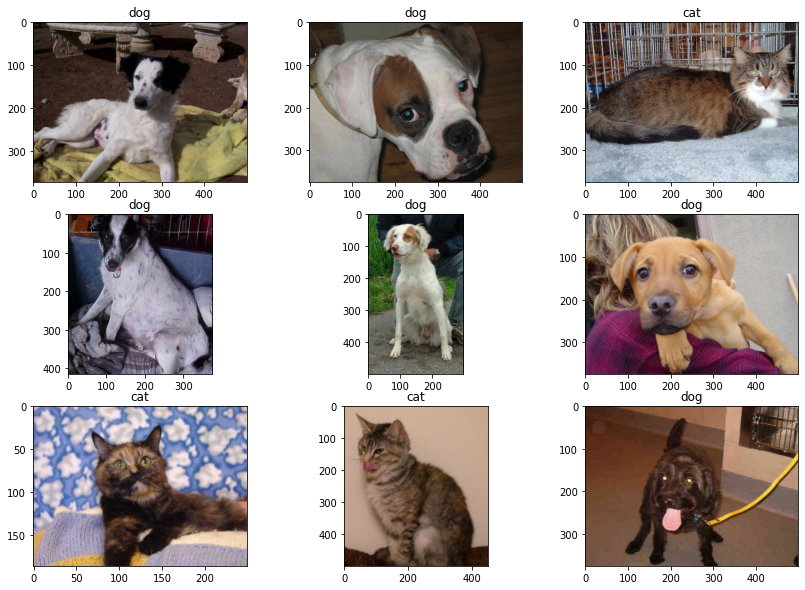

In [9]:
import random
def view_random_image(target_dir, class_names, number=9):
    plt.figure(figsize=(14,10))

    for i in range(number):
        if type(class_names) == list:
            target_class = np.random.choice(class_names)
        else:
            target_class = class_names
            
        target_folder = target_dir+target_class
        random_image = random.sample(os.listdir(target_folder), 1)
        img = imread(target_folder + "/" + random_image[0])
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.title(target_class);
        print(f"Image shape: {img.shape}") # show the shape of the image

img = view_random_image(train_path,class_names, 9)

In [10]:
lr = 0.001 # learning_rate
batch_size = 100 # we will use mini-batch method
epochs = 10 # How much to train a model

In [11]:
train_transforms =  transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation((-30,30)),
        transforms.ToTensor()])
    

val_transforms = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()])

test_transforms = transforms.Compose([   
    transforms.Resize((128, 128)),
    transforms.ToTensor()])

In [12]:
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
validation_data = datasets.ImageFolder(val_path, transform=val_transforms)
# test_data = datasets.ImageFolder(test_path, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

torch.Size([128, 128, 3])


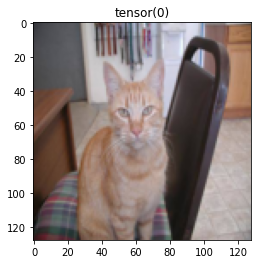

In [13]:
data_iter = iter(validation_loader)

images, labels = next(data_iter)

plt.imshow( torch.permute(images[0], (1, 2, 0)))
plt.title(labels[0])
print(torch.permute(images[0], (1, 2, 0)).shape)

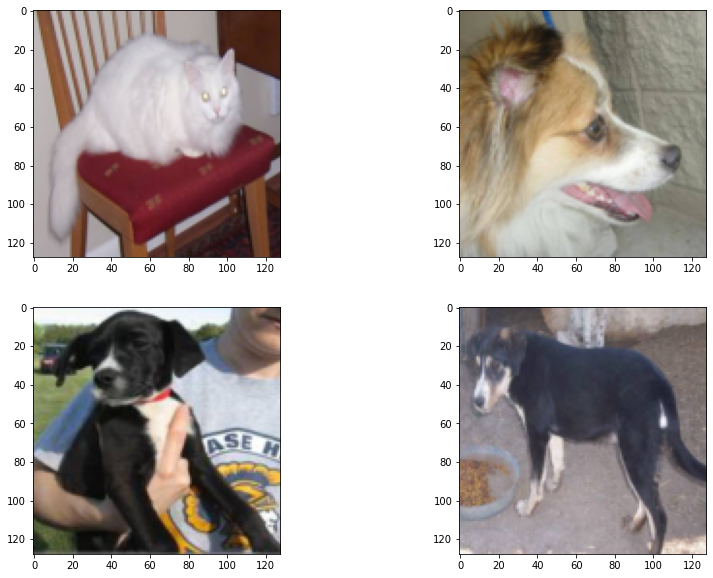

In [14]:
data_iter = iter(validation_loader)
images, labels = next(data_iter)

plt.figure(figsize=(14,10))
for ii in range(4):
    plt.subplot(2,2,ii+1)
    plt.imshow( torch.permute(images[ii], (1, 2, 0)))

# Model 1

In [15]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(16*16*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [17]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=16384, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linea

In [18]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [19]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in validation_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(validation_loader)
            epoch_val_loss += val_loss/ len(validation_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.7118709087371826, train loss : 0.5502107739448547
Epoch : 1, val_accuracy : 0.5327932238578796, val_loss : 0.6415163278579712
Epoch : 2, train accuracy : 0.7542300820350647, train loss : 0.5037106275558472
Epoch : 2, val_accuracy : 0.7060184478759766, val_loss : 0.626826822757721
Epoch : 3, train accuracy : 0.7883627414703369, train loss : 0.47944971919059753
Epoch : 3, val_accuracy : 0.7456113696098328, val_loss : 0.5820248126983643
Epoch : 4, train accuracy : 0.7955220341682434, train loss : 0.4625929594039917
Epoch : 4, val_accuracy : 0.7473475337028503, val_loss : 0.574558675289154
Epoch : 5, train accuracy : 0.7985650300979614, train loss : 0.4495079815387726
Epoch : 5, val_accuracy : 0.7432001829147339, val_loss : 0.5492403507232666
Epoch : 6, train accuracy : 0.8093212246894836, train loss : 0.43202024698257446
Epoch : 6, val_accuracy : 0.7558351755142212, val_loss : 0.5447565317153931
Epoch : 7, train accuracy : 0.812286913394928, train loss : 0.42

# Model 2

In [20]:
# class EarlyStopping():
#     def __init__(self, tolerance=5, min_delta=0):

#         self.tolerance = tolerance
#         self.min_delta = min_delta
#         self.counter = 0
#         self.early_stop = False

#     def __call__(self, train_loss, validation_loss):
#         if (validation_loss - train_loss) > self.min_delta:
#             self.counter +=1
#             if self.counter >= self.tolerance:  
#                 self.early_stop = True

In [25]:
class Cnn2(nn.Module):
    def __init__(self):
        super(Cnn2,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        
        self.fc1 = nn.Linear(8*8*128,128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [26]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model2 = Cnn2().to(device)
model2.train()

cuda


Cnn2(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()

In [27]:
optimizer = optim.Adam(params = model2.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [35]:
epochs = 10
early_stopping = EarlyStopping(tolerance=5, min_delta=10)
train_accuracy_list=[]
train_loss_list=[]
validation_loss_list=[]
validation_accuracy_list=[]

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model2(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
    
    train_accuracy_list.append(epoch_accuracy)
    train_loss_list.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in validation_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(validation_loader)
            epoch_val_loss += val_loss/ len(validation_loader)
        
        validation_accuracy_list.append(epoch_val_accuracy)
        validation_loss_list.append(epoch_val_loss)   
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.7905606031417847, train loss : 0.45042136311531067
Epoch : 1, val_accuracy : 0.7990933060646057, val_loss : 0.46637827157974243
Epoch : 2, train accuracy : 0.7999901175498962, train loss : 0.43414291739463806
Epoch : 2, val_accuracy : 0.8027102947235107, val_loss : 0.46278250217437744
Epoch : 3, train accuracy : 0.8061854839324951, train loss : 0.42801591753959656
Epoch : 3, val_accuracy : 0.7955245971679688, val_loss : 0.4608829915523529
Epoch : 4, train accuracy : 0.810234010219574, train loss : 0.41642671823501587
Epoch : 4, val_accuracy : 0.7936438918113708, val_loss : 0.4618557095527649
Epoch : 5, train accuracy : 0.8164756298065186, train loss : 0.40456393361091614
Epoch : 5, val_accuracy : 0.7984663248062134, val_loss : 0.4625036120414734
Epoch : 6, train accuracy : 0.8179845809936523, train loss : 0.4011768400669098
Epoch : 6, val_accuracy : 0.7989486455917358, val_loss : 0.4624662399291992
Epoch : 7, train accuracy : 0.8250862956047058, train loss

In [57]:
trainacc_list=[]
trainloss_list=[]
validationloss_list=[]
validationacc_list=[]
# train_accuracy_list=[]
# train_loss_list=[]
# validation_loss_list=[]
# validation_accuracy_list=[]
for i in range(10):
    trainacc_list.append(train_accuracy_list[i].item())
    trainloss_list.append(train_loss_list[i].item())
    validationloss_list.append(validation_loss_list[i].item())
    validationacc_list.append(validation_accuracy_list[i].item())

total = {"TrainLoss" : trainloss_list, "ValLoss" : validationloss_list,"TrainAccuracy" : trainacc_list, "ValAccuracy": validationacc_list}
summary = pd.DataFrame(total)
summary

,TrainLoss,ValLoss,TrainAccuracy,ValAccuracy
0,0.450421,0.466378,0.790561,0.799093
1,0.434143,0.462783,0.799990,0.802710
2,0.428016,0.460883,0.806185,0.795525
3,0.416427,0.461856,0.810234,0.793644
4,0.404564,0.462504,0.816476,0.798466
5,0.401177,0.462466,0.817985,0.798949
6,0.386573,0.457274,0.825086,0.801746
7,0.380636,0.460698,0.830587,0.801071
8,0.372205,0.466853,0.832754,0.797357
9,0.366363,0.459673,0.837564,0.798997


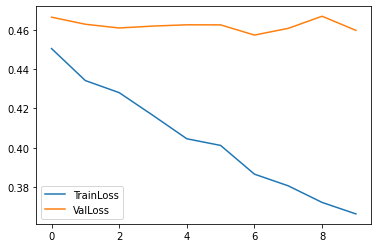

In [56]:
summary[["TrainLoss", "ValLoss"]].plot();

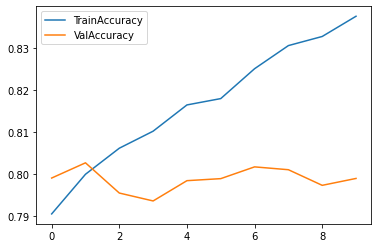

In [58]:
summary[["TrainAccuracy", "ValAccuracy"]].plot();

In [107]:
dog_probs = []
model.eval()
result = {"y_test" : [], "y_pred" : []}
with torch.no_grad():
    for data, fileid in validation_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))
#         dog_probs += list(zip(list(fileid[0].item()), preds_list))

In [108]:
y_test = []
y_pred = []
for i in dog_probs:
    y_test.append(i[0].item())
    y_pred.append(1 if i[1] > 0.5 else 0)

In [109]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y_test,y_pred))
print("-----"*20)
print(classification_report(y_test,y_pred))

[[1072  147]
 [ 307  764]]
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1219
           1       0.84      0.71      0.77      1071

    accuracy                           0.80      2290
   macro avg       0.81      0.80      0.80      2290
weighted avg       0.81      0.80      0.80      2290

